In [80]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import percentile
import numpy as np
from scipy.stats import iqr
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

Instantiating the "read_csv()" function for each '.csv' files.

In [2]:
# French outlets
tva = pd.read_csv('TVAnouvelles_facebook_statuses.csv')
radiocanada = pd.read_csv('radiocanada.info_facebook_statuses.csv')
# English outlets
ctv = pd.read_csv('CTVNews_facebook_statuses.csv')
cbc = pd.read_csv('cbcnews_facebook_statuses.csv')

Our data frame's columns.

In [3]:
tva.columns

Index(['status_id', 'status_message', 'link_name', 'status_type',
       'status_link', 'status_published', 'num_reactions', 'num_comments',
       'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas',
       'num_sads', 'num_angrys', 'num_special'],
      dtype='object')

Our data frame first row.

In [4]:
tva[:1]

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,num_special
0,163706859094_10156641770669095,Une hausse de 4500% en 4 ans 😲,Le nombre de drones qui survolent nos prisons ...,link,http://www.tvanouvelles.ca/2018/05/13/le-nombr...,2018-05-13 22:02:08,116,21,45,55,4,18,36,0,3,0


# Data cleaning

Grabbing all posts after "2016-02-24". (Facebook started using "reactions" at that date)

(https://newsroom.fb.com/news/2016/02/reactions-now-available-globally/)

(Not clearing outliers for the sake of data integrity)

In [5]:
tva_clean = tva.where(tva.status_published >= '2016-02-24').dropna().reset_index(drop=True)
radiocanada_clean = radiocanada.where(radiocanada.status_published >= '2016-02-24').dropna().reset_index(drop=True)

ctv_clean = ctv.where(ctv.status_published >= '2016-02-24').dropna().reset_index(drop=True)
cbc_clean = cbc.where(cbc.status_published >= '2016-02-24').dropna().reset_index(drop=True)

Appending TVA with Radio-Canada and CTV News with CBC News, we end up with a French and English data frame.

In [6]:
french = tva_clean.append(radiocanada_clean).reset_index(drop=True)
english = ctv_clean.append(cbc_clean).reset_index(drop=True)

Since we don't need 'num_special' we'll clear them out from our data frames.

In [7]:
french = french.where(french.num_special == 0).dropna().reset_index(drop=True)
english = english.where(english.num_special == 0).dropna().reset_index(drop=True)

We don't need 'num_likes', let's subtract it from 'num_reactions' since we want the exact sum of all sentiments. 

('num_reactions' is the sum of all reactions 'Likes', 'Loves', 'Hahas', 'Angrys', etc.)

In [8]:
french['num_reactions'] = french['num_reactions'] - french['num_likes']
english['num_reactions'] = english['num_reactions'] - english['num_likes']

Let's grab our columns of interest

In [9]:
french = french[['num_reactions','num_comments','num_shares','num_loves','num_wows','num_hahas','num_sads','num_angrys']]
english =  english[['num_reactions','num_comments','num_shares','num_loves','num_wows','num_hahas','num_sads','num_angrys']]

We end up with a clean data frame

In [10]:
french.head()

,num_reactions,num_comments,num_shares,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,61.0,21.0,45.0,4.0,18.0,36.0,0.0,3.0
1,168.0,70.0,27.0,150.0,3.0,5.0,1.0,9.0
2,194.0,37.0,125.0,21.0,126.0,0.0,47.0,0.0
3,100.0,52.0,13.0,87.0,0.0,10.0,0.0,3.0
4,54.0,81.0,10.0,45.0,2.0,7.0,0.0,0.0


In [11]:
french.tail()

,num_reactions,num_comments,num_shares,num_loves,num_wows,num_hahas,num_sads,num_angrys
3523,62.0,81.0,97.0,1.0,9.0,29.0,8.0,15.0
3524,21.0,49.0,55.0,8.0,9.0,3.0,0.0,1.0
3525,131.0,38.0,29.0,65.0,21.0,9.0,8.0,28.0
3526,55.0,78.0,41.0,4.0,5.0,7.0,11.0,28.0
3527,26.0,20.0,50.0,1.0,0.0,1.0,6.0,18.0


# Sentiment correlation analysis

'num_reactions', 'num_comments' and 'num_shares' are the 3 main ways users interact with posts on Facebook

Note: (> 0.50) is considered highly correlated (i.e > 50%)

('num_reactions' is the sum of all 'reactions', i.e Love, Haha, Sad, etc.)

Grabbing same amount of posts for 'french' and 'english' posts 

In [12]:
french = french[:3528]
english = english[:3528]

French and English correlation plot

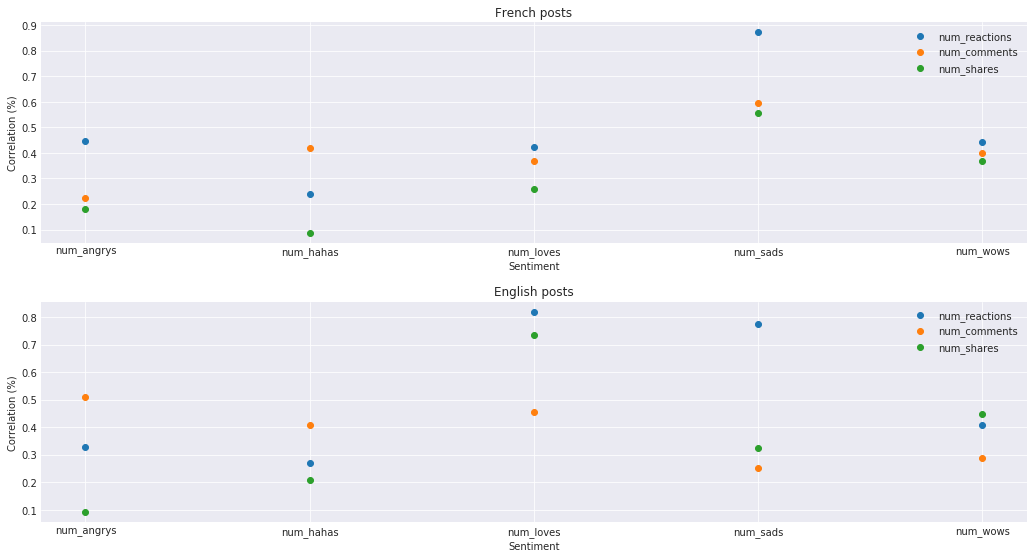

In [13]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=[15,8])

    plt.subplot(211)
    plt.title('French posts')
    plt.xlabel('Sentiment')
    plt.ylabel('Correlation (%)')
    plt.plot(french.corr()[['num_reactions','num_comments','num_shares']][3::],'o')
    plt.legend(['num_reactions','num_comments','num_shares'])
    
    plt.tight_layout(pad=3)
    
    plt.subplot(212)
    plt.title('English posts')
    plt.xlabel('Sentiment')
    plt.ylabel('Correlation (%)')
    plt.plot(english.corr()[['num_reactions','num_comments','num_shares']][3::],'o')
    plt.legend(['num_reactions','num_comments','num_shares'])

French sentiment correlation

In [14]:
french.corr()[['num_reactions','num_comments','num_shares']][3::].round(decimals=2)

,num_reactions,num_comments,num_shares
num_loves,0.42,0.37,0.26
num_wows,0.44,0.40,0.37
num_hahas,0.24,0.42,0.09
num_sads,0.87,0.59,0.55
num_angrys,0.45,0.22,0.18


'num_sads' is highly correlated with 'num_reactions', which indicates that 'sad' tend to be high on posts with high 'reactions'.

(We can also say that the majority of the 'reaction' surge on a post is due to 'sad')

In [15]:
french.corr()[['num_reactions','num_comments','num_shares']][['num_reactions']][6::6].round(decimals=2)

,num_reactions
num_sads,0.87


'num_sads' is also highly correlated with 'num_comments', comments tend to be high on posts with many 'sads'.

In [16]:
french.corr()[['num_reactions','num_comments','num_shares']][['num_comments']][6::6].round(decimals=2)

,num_comments
num_sads,0.59


'num_sads' has a high correlation with 'num_shares', posts with many 'sads' on them tend to be shared alot.

In [17]:
french.corr()[['num_reactions','num_comments','num_shares']][['num_shares']][6::6].round(decimals=2)

,num_shares
num_sads,0.55


English sentiment correlation

In [18]:
english.corr()[['num_reactions','num_comments','num_shares']][3::].round(decimals=2)

,num_reactions,num_comments,num_shares
num_loves,0.82,0.46,0.73
num_wows,0.41,0.29,0.45
num_hahas,0.27,0.41,0.21
num_sads,0.78,0.25,0.33
num_angrys,0.33,0.51,0.09


'num_reactions' is highly correlated with 'num_loves' and 'num_sads', both 'sad' and 'love' tend to be high on posts with high 'reactions'

In [19]:
english.corr()[['num_reactions','num_comments','num_shares']][['num_reactions']][3::3].round(decimals=2)

,num_reactions
num_loves,0.82
num_sads,0.78


'num_comments' has a high correlation with num_angrys, posts with alot of 'angry' tend to have more comments.

In [20]:
english.corr()[['num_reactions','num_comments','num_shares']][['num_comments']][7::7].round(decimals=2)

,num_comments
num_angrys,0.51


'num_shares' is highly correlated with 'num_loves', posts with alot of 'love' are more likely to be shared

In [21]:
english.corr()[['num_reactions','num_comments','num_shares']][['num_shares']][3::5].round(decimals=2)

,num_shares
num_loves,0.73


# Linear model using linear regression

French (Sad/Comments) linear regression

In [273]:
# Instantiating
linreg = LinearRegression()

In [274]:
X = french.num_sads.values.reshape(-1,1)
y = french.num_comments

In [275]:
# Splitting data set 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,random_state=10)

In [276]:
# Fitting model
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [277]:
# Predicting
y_pred = linreg.predict(X_test)

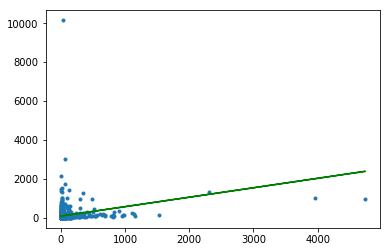

In [278]:
# Plotting
plt.scatter(X_test,y_test,marker='.')
plt.plot(X_test,y_pred,'g')

In [279]:
# Model score
linreg.score(X_train,y_train)

0.4623721789726578

English Sad/Comments linear regression

In [280]:
#Instantiating
linreg = LinearRegression()

In [281]:
X = english.num_sads.values.reshape(-1,1)
y = english.num_comments

In [282]:
# Splitting data set
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,random_state=10)

In [283]:
# Fitting model
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [284]:
# Predicting
y_pred = linreg.predict(X_test)

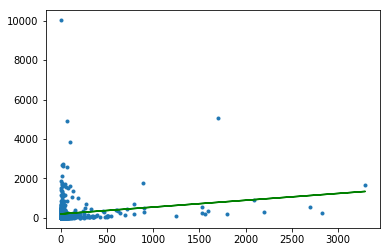

In [285]:
# Plotting
plt.scatter(X_test,y_test,marker='.')
plt.plot(X_test,y_pred,'g')

In [286]:
# Model score
linreg.score(X_train,y_train)

0.06628681812394277